In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from preamble import *
from preamble.dynesty.RLS_surf import *

In [20]:
peakbag = np.load("pooled_lw_rot.npy", allow_pickle=True)[()]['summary']['new_samples']
β = np.load("β.npy", allow_pickle=True)[()]

β1 = β['β1']
β2 = β['β2']

δν1 = peakbag[:, 5] / β1
δν2 = peakbag[:, 6] / β2

In [21]:
from astropy import units as u, constants as c

Vsini = 10.1 * u.km/u.s
e_Vsini = 0.7* u.km/u.s

i = np.median(peakbag[:, 0])
e_i = np.std(peakbag[:, 0])

R = 23.5 * u.R_sun
e_R = 0.03 * u.R_sun

νrot = (Vsini / np.sin(i) / R / 2 / np.pi).to(u.uHz)
e_νrot = νrot * np.sqrt((e_Vsini/Vsini)**2 + (e_R/R)**2 + (e_i / np.tan(i))**2)

νrot

<Quantity 0.09878197 uHz>

  0%|          | 0/34170 [00:00<?, ?it/s]

  0%|          | 0/35824 [00:00<?, ?it/s]

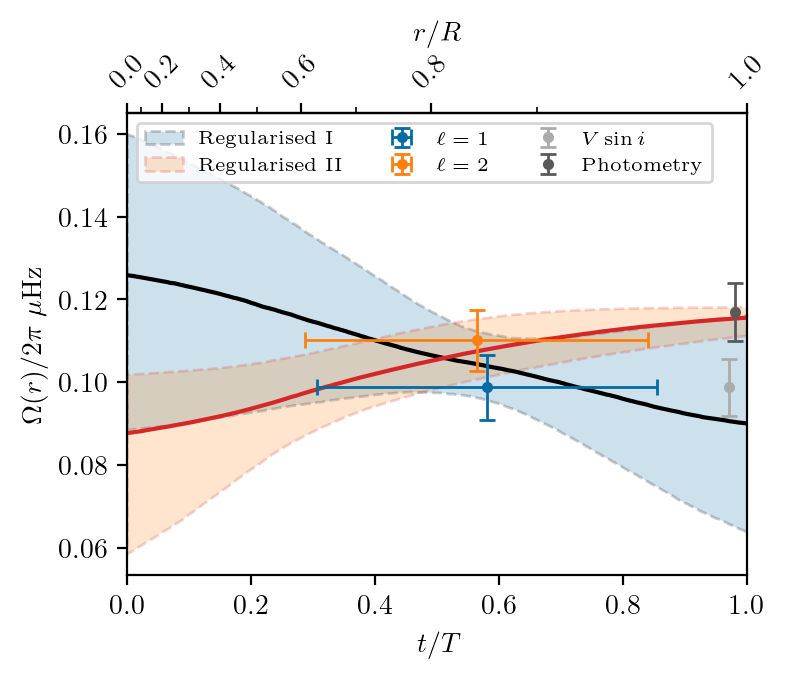

In [26]:
summary = np.load("RLS.npy", allow_pickle=True)[()]['summary']['new_samples']

ν_rot = summary[:, 5]
δν_rot = summary[:, 6]

ν_in = ν_rot - δν_rot/2
ν_out = ν_rot + δν_rot/2

t_shear = summary[:, 7]
Δt_shear = summary[:, 8]

tt = np.linspace(0, 1, 1000)

all_profiles = np.array([rotational_profile(tt, a, b, c, d) for a, b, c, d in zip(tqdm(ν_rot), δν_rot, t_shear, Δt_shear)])
Δ = [_[-1] - _[0] for _ in all_profiles]
a = np.argsort(Δ)

# for i in range(1, len(ν_rot), 100):
#     p = all_profiles[a[i]]
#     plt.plot(tt, p, alpha=.1, c='tab:blue' if p[-1] < p[0] else 'tab:red', lw=.7)

plt.plot(tt, np.median(all_profiles, axis=0), c='black')

from scipy.stats import norm
bounds = [np.quantile(all_profiles, norm.cdf(z), axis=0) for z in (-1, 1)]
plt.fill_between(tt, *bounds, edgecolor='black', lw=1, ls='dashed', alpha=.2, label=r"Regularised I")

summary = np.load("RLS_surf.npy", allow_pickle=True)[()]['summary']['new_samples']

ν_in = summary[:, 5]
ν_out = SURF_RATE

ν_rot = (ν_in + ν_out)/2
δν_rot = ν_out - ν_in

t_shear = summary[:, 6]
Δt_shear = summary[:, 7]

tt = np.linspace(0, 1, 1000)

all_profiles = np.array([rotational_profile(tt, a, b, c, d) for a, b, c, d in zip(tqdm(ν_rot), δν_rot, t_shear, Δt_shear)])
Δ = [_[-1] - _[0] for _ in all_profiles]
a = np.argsort(Δ)

# for i in range(1, len(ν_rot), 100):
#     p = all_profiles[a[i]]
#     plt.plot(tt, p, alpha=.1, c='tab:blue' if p[-1] < p[0] else 'tab:red', lw=.7)

plt.plot(tt, np.median(all_profiles, axis=0), c='tab:red')

from scipy.stats import norm
bounds = [np.quantile(all_profiles, norm.cdf(z), axis=0) for z in (-1, 1)]
plt.fill_between(tt, *bounds, edgecolor='tab:red', facecolor="C1", lw=1, ls='dashed', alpha=.2, label="Regularised II")

# Centres of sensitivity

epoint = dict(capsize=3, fmt='.', elinewidth=1)

surf_rate = (1/(99 * u.d)).to(u.uHz).value

plt.errorbar([0.5799520254830849], [np.median(δν1)], xerr=[0.2740736751307916], yerr=[np.std(δν1)], label=r'$\ell = 1$', **epoint, c="C0")
plt.errorbar([0.5632657659436561], [np.median(δν2)], xerr=[0.276172825954183], yerr=[np.std(δν2)], label=r'$\ell = 2$', **epoint, c="C1")
plt.errorbar([.97], [νrot.value], yerr=[e_νrot.value], **epoint, label="$V \sin i$", c="C2")
plt.errorbar([.98], [surf_rate], yerr=[surf_rate * np.sqrt(5**2 + 3**2)/98], **epoint, label="Photometry", c='C3')

plt.legend(loc='upper left', ncol=3, fontsize="x-small")

# All done

plt.xlim(0, 1)
plt.xlabel(r"$t/T$")
plt.ylabel(r"$\Omega(r)/2\pi\ \mu$Hz")

# secondary x-xaxis

R = float(eig[1]._info[0].R_star)
secax = plt.gca().secondary_xaxis('top', functions=(lambda x: np.interp(x, t[1], eig[1].r/R),
                                                    lambda x: np.interp(x, eig[1].r/R, t[1])))

from matplotlib.ticker import FixedLocator
secax.set_xlabel('$r/R$')
for tick in secax.get_xticklabels():
    tick.set_rotation(45)
secax.xaxis.set_minor_locator(FixedLocator(np.arange(5)*.2+.1))

plt.gcf().set_size_inches(4,3)
plt.savefig(r"rot_summary.pdf", bbox_inches='tight', transparent=True)
plt.show()